<a href="https://colab.research.google.com/github/volfenstein1/dida_segmentation_task/blob/main/1_dida_segmentation_task_initial_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Developing and optimizing a deep learning model is sometimes treated as more of an art than a science, with little documentation, guesswork, and fiddling involved to get results.

In this project, I seek to implement a more systematic approach to developing a model for the task at hand.
I followed the notes from Damek Davis's course notes:
[A Playbook for Tuning Deep Learning Models](https://damek.github.io/STAT-4830/section/11/notes.html), which themselves are based off of Google research's [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook).
Quoting Davis: "The core idea is to move beyond ad-hoc adjustments and adopt an iterative, scientific approach."

The process can be described simply as follows:
1. Establish an initial baseline model.
2. Iteratively improve modelling choices and hyperparameter optimizations.
3. Upon making final model choices, exploit for a final training run whose "sole aim is minimizing validation error".

In this notebook, I establish a baseline initial model for the task at hand, to understand the structure of the problem and give a base for further improvement.

I did not have any experience in image segmentation tasks; for understanding and developing this task, I learned a lot from the Kaggle competition [Carvana Image Masking Challenge](https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview). In particular, the write-up of the [first place submission](https://medium.com/kaggle-blog/carvana-image-masking-challenge-1st-place-winners-interview-78fcc5c887a8) was insightful.

In [ ]:
%%capture
!pip install torchvision;
!pip install segmentation-models-pytorch;
!pip install albumentationsx;

In [ ]:
from google.colab import drive
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss, SoftBCEWithLogitsLoss, SoftCrossEntropyLoss, JaccardLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, f1_score
import albumentations as A

# The data

Since I am working with a Google colab notebook, which do not persist local data, it is easiest to access the data via mounted google drive folders.

The data consists of 25 image / label pairs, and 5 images without labels, as a holdout set. I manually separated the 5 images without labels into a folder 'to_predict'.

Let's load and inspect the data. It consists of:

- Image PNGs. Each image is a satellite photo of some buildings and surroundings. Each image is a 256x256 PNG file with 4 channels (RGBA) corresponding to Red, Green, Blue, and an Alpha transparency channel.
- Label PNGs. Each label is associated to an image, and is a segmentation mask, identifying the roof of the buildings. Each label is a 256x256 PNG file with 1 channel (L), as the images are grayscale.

The data set is extremely small. This is an interesting limitation to work around. Later, I will partially work around this limitation through the use of image augmentations. (I could of course also train a model on a larger representative dataset, for example, the [Massachusetts Buildings Dataset](https://www.cs.toronto.edu/~vmnih/data/); I choose not to do this however, as my goal with the project is to demonstrate my iterative approach and workflow to the problem at hand with the data at hand.)

I also observe:
- I do not know the **data generating process** for the segmentation masks. Most likely, they are generated manually by humans; in which case we should ask about the software used for this generation or the methodology.
- I also do not know for what purpose the resulting image segmentation masks will be used. For example, the masks might be used to subsequently estimate the area of the rooftops.
For an example project this is not a huge problem; however answers to these questions would be relevant for any serious production level solution.

## Data Cleaning
The dataset was small enough to inspect manually. This was important, as image 278 and label 278 do not match. I removed them both from the dataset.


In [ ]:
drive.mount("/mnt/drive")

images_path = "/mnt/drive/MyDrive/dida/images"
labels_path = "/mnt/drive/MyDrive/dida/labels"
to_predict = "/mnt/drive/MyDrive/dida/to_predict"

Mounted at /mnt/drive


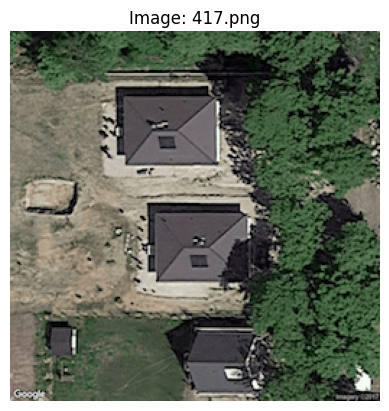

Image format: PNG
Image mode: RGBA
Image size: (256, 256)


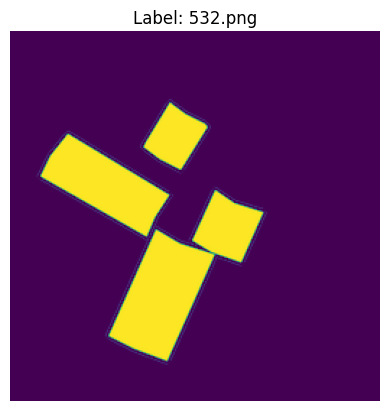

Label format: PNG
Label mode: L
Label size: (256, 256)


In [ ]:
image_files = os.listdir(images_path)
first_image_file = image_files[0]
first_image_path = os.path.join(images_path, first_image_file)

img = Image.open(first_image_path)

# Display the first image
plt.imshow(img)
plt.title(f"Image: {first_image_file}")
plt.axis('off')
plt.show()

print(f"Image format: {img.format}")
print(f"Image mode: {img.mode}")
print(f"Image size: {img.size}")

label_files = os.listdir(labels_path)
first_label_file = label_files[0]
first_label_path = os.path.join(labels_path, first_label_file)

img = Image.open(first_label_path)

# Display the first label
plt.imshow(img)
plt.title(f"Label: {first_label_file}")
plt.axis('off')
plt.show()

print(f"Label format: {img.format}")
print(f"Label mode: {img.mode}")
print(f"Label size: {img.size}")

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.common_filenames = sorted(f for f in os.listdir(image_dir) if f in os.listdir(label_dir))

    def __len__(self):
        return len(self.common_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.common_filenames[idx])
        label_path = os.path.join(self.label_dir, self.common_filenames[idx])

        image_pil = Image.open(image_path)
        label_pil = Image.open(label_path)

        image_tensor = ToTensor()(image_pil)
        label_tensor = ToTensor()(label_pil)

        return image_tensor, label_tensor

In [ ]:
ds = SegmentationDataset(images_path, labels_path)

print("Size of the dataset:", len(ds))

train_size = 20
val_size = 4
train_dataset, val_dataset = torch.utils.data.random_split(ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

Size of the dataset: 24


Image batch shape:  torch.Size([20, 4, 256, 256])
Label batch shape:  torch.Size([20, 1, 256, 256])


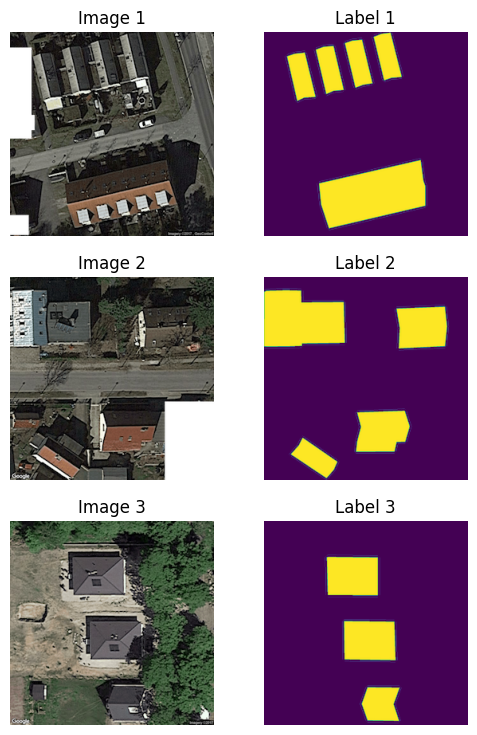

In [ ]:
batch0 = next(iter(train_loader))

print("Image batch shape: ", batch0[0].shape)
print("Label batch shape: ", batch0[1].shape)

images_to_display = 3
plt.figure(figsize=(6, 9))
for idx in range(images_to_display):
    # Display image
    plt.subplot(images_to_display, 2, 2*idx + 1)
    # Change dimensions from (C, H, W) to (H, W, C) for displaying
    plt.imshow(np.transpose(batch0[0][idx].numpy(), (1, 2, 0)))
    plt.title(f"Image {idx + 1}")
    plt.axis('off')

    # Display label
    plt.subplot(images_to_display, 2, 2*idx + 2)
    # Change dimensions from (C, H, W) to (H, W, C) for displaying
    plt.imshow(np.transpose(batch0[1][idx].numpy(), (1, 2, 0)))
    plt.title(f"Label {idx + 1}")
    plt.axis('off')

plt.show()

# Initial Baseline

Prior to any attempts at iterative improvement, here I establish an intial baseline for the model.

My initial choices were informed by the following resources:
[Carvana Image Masking Challenge–1st Place Winner’s Interview](https://medium.com/kaggle-blog/carvana-image-masking-challenge-1st-place-winners-interview-78fcc5c887a8),
[Image Segmentation – Choosing the Correct Metric](https://towardsdatascience.com/image-segmentation-choosing-the-correct-metric-aa21fd5751af/).

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
model = smp.Unet(
    encoder_name="resnet152",
    encoder_weights="imagenet",
    in_channels=4,
    classes=1,
    activation='sigmoid'
)

# Move the model to the device
model.to(device)

# Define the optimizer
optimizer = optim.Adagrad(model.parameters(), lr=1e-4)

focal_loss = FocalLoss(mode="binary")
dice_loss = DiceLoss(mode="binary")
log_dice_loss = DiceLoss(mode="binary", log_loss=True)
bce_loss = SoftBCEWithLogitsLoss()

# Define the loss function
loss_function = dice_loss

# Training loop
num_epochs = 200

train_losses = []
train_dices = []
train_focals = []
train_bces = []
train_accuracies = []
train_f1_scores = []

val_losses = []
val_dices = []
val_focals = []
val_bces = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_focal = 0.0
    running_bce = 0.0
    running_accuracy = 0.0
    running_f1 = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = loss_function(outputs, labels)

        # Calculate other metrics
        batch_dice = 1.0 - dice_loss(outputs, labels)
        batch_focal = focal_loss(outputs, labels)
        batch_bce = bce_loss(outputs, labels)

        labels_long = labels.long()
        tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
        batch_accuracy = accuracy(tp, fp, fn, tn).mean()
        batch_f1 = f1_score(tp, fp, fn, tn).mean()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        running_focal += batch_focal.item()
        running_bce += batch_bce.item()
        running_dice += batch_dice.item()
        running_accuracy += batch_accuracy.item()
        running_f1 += batch_f1.item()

    train_losses.append(running_loss / len(train_loader))
    train_focals.append(running_focal / len(train_loader))
    train_bces.append(running_bce / len(train_loader))
    train_dices.append(running_dice / len(train_loader))
    train_accuracies.append(running_accuracy / len(train_loader))
    train_f1_scores.append(running_f1 / len(train_loader))

    # Print metrics every 10 steps
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Training Loss: {train_losses[-1]:.4f}, Training Dice: {train_dices[-1]:.4f}, Training Focals: {train_focals[-1]:.4f}, Training BCE: {train_bces[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}, Training F1: {train_f1_scores[-1]:.4f}')

    # Evaluation loop after each epoch
    # Set the model to evaluation mode
    model.eval()
    validation_loss = 0.0
    validation_dice = 0.0
    validation_focal = 0.0
    validation_bce = 0.0
    validation_accuracy = 0.0
    validation_f1 = 0.0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_function(outputs, labels)

            # Calculate other metrics
            batch_dice = 1.0 - dice_loss(outputs, labels)
            batch_focal = focal_loss(outputs, labels)
            batch_bce = bce_loss(outputs, labels)

            labels_long = labels.long()
            tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
            batch_accuracy = accuracy(tp, fp, fn, tn).mean()
            batch_f1 = f1_score(tp, fp, fn, tn).mean()

            # Update running metrics
            validation_loss += loss.item()
            validation_dice += batch_dice.item()
            validation_focal += batch_focal.item()
            validation_bce += batch_bce.item()
            validation_accuracy += batch_accuracy.item()
            validation_f1 += batch_f1.item()

    val_losses.append(validation_loss / len(val_loader))
    val_dices.append(validation_dice / len(val_loader))
    val_focals.append(validation_focal / len(val_loader))
    val_bces.append(validation_bce / len(val_loader))
    val_accuracies.append(validation_accuracy / len(val_loader))
    val_f1_scores.append(validation_f1 / len(val_loader))

    # Print metrics every 10 steps
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Validation Loss: {val_losses[-1]:.4f}, Validation Dice: {val_dices[-1]:.4f}, Validation Focal: {val_focals[-1]:.4f}, Validation BCE: {val_bces[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}, Validation F1: {val_f1_scores[-1]:.4f}')

print('Finished Training')

Using device: cuda


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Epoch [10/200] finished. Training Loss: 0.7240, Training Dice: 0.2760, Training Focals: 0.2571, Training BCE: 0.7943, Training Accuracy: 0.8762, Training F1: 0.6526
Epoch [10/200] finished. Validation Loss: 0.7757, Validation Dice: 0.2243, Validation Focal: 0.3425, Validation BCE: 0.9142, Validation Accuracy: 0.4177, Validation F1: 0.2249
Epoch [20/200] finished. Training Loss: 0.7171, Training Dice: 0.2829, Training Focals: 0.2427, Training BCE: 0.7741, Training Accuracy: 0.9122, Training F1: 0.7290
Epoch [20/200] finished. Validation Loss: 0.7685, Validation Dice: 0.2315, Validation Focal: 0.3463, Validation BCE: 0.9138, Validation Accuracy: 0.4857, Validation F1: 0.2767
Epoch [30/200] finished. Training Loss: 0.7145, Training Dice: 0.2855, Training Focals: 0.2356, Training BCE: 0.7643, Training Accuracy: 0.9263, Training F1: 0.7639
Epoch [30/200] finished. Validation Loss: 0.7648, Validation Dice: 0.2352, Validation Focal: 0.3234, Validation BCE: 0.8850, Validation Accuracy: 0.6249,

# Plots of the training metrics

To help us visualize the training process, I plot the training / validation metrics against the number of epochs.

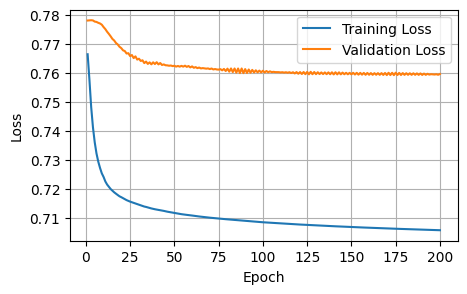

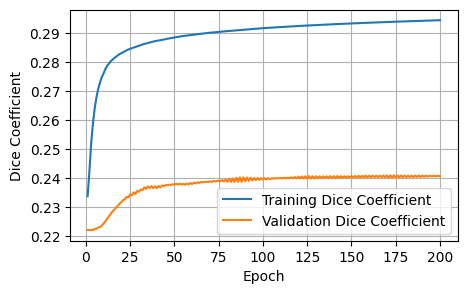

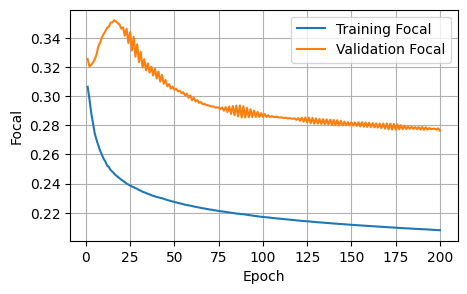

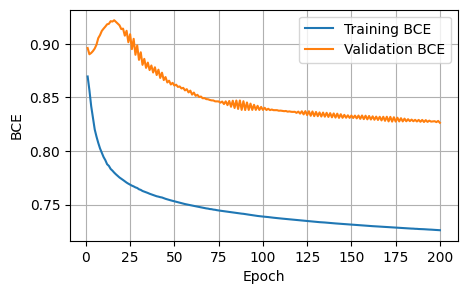

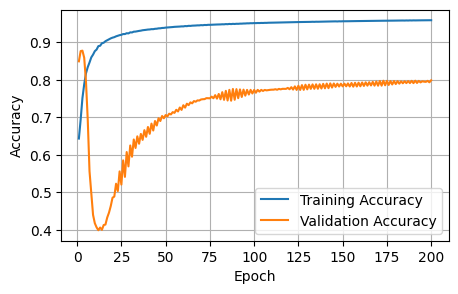

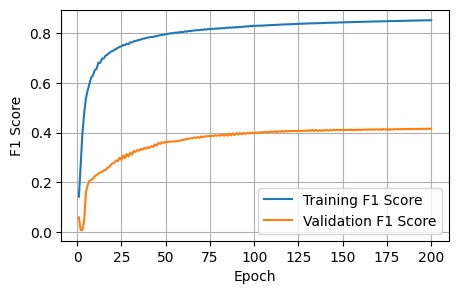

In [ ]:
data = {
    'Epoch': range(1, len(train_losses) + 1),
    'Training Loss': train_losses,
    'Training Dice': train_dices,
    'Training Focal': train_focals,
    'Training BCE': train_bces,
    'Training Accuracy': train_accuracies,
    'Training F1 Score': train_f1_scores,
    'Validation Loss': val_losses,
    'Validation Dice': val_dices,
    'Validation Focal': val_focals,
    'Validation BCE': val_bces,
    'Validation Accuracy': val_accuracies,
    'Validation F1 Score': val_f1_scores,
}

metrics_df = pd.DataFrame(data)

def plot_metrics(train_metrics, val_metrics, metric_name):
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, train_metrics, label=f'Training {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(train_losses, val_losses, 'Loss')
plot_metrics(train_dices, val_dices, 'Dice Coefficient')
plot_metrics(train_focals, val_focals, 'Focal')
plot_metrics(train_bces, val_bces, 'BCE')
plot_metrics(train_accuracies, val_accuracies, 'Accuracy')
plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')

The initial baseline is acceptable; the curves show improvement, and our training setup works as intended. In the next notebook, I will iteratively improve on the various model choices.

# Predictions

Of course, the goal of the project is to make predictions on five unlabeled images. I show how we can do that here. (There is clearly room for improvement in the subsequent notebooks.)

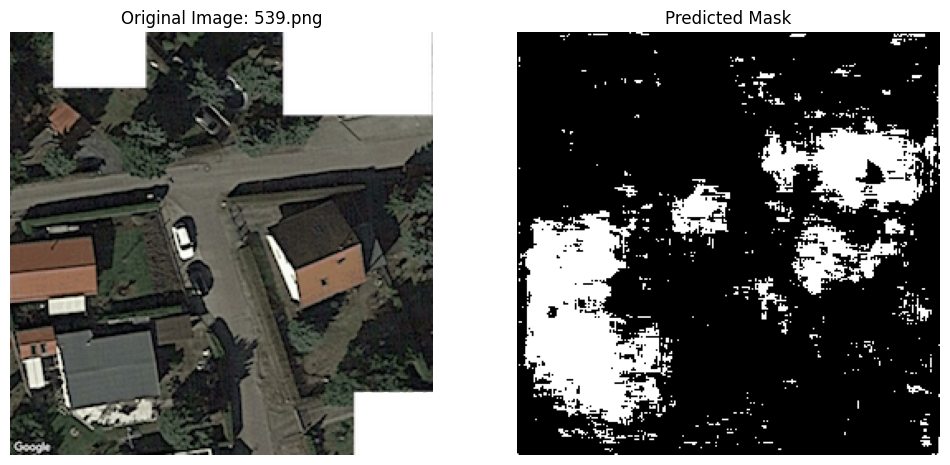

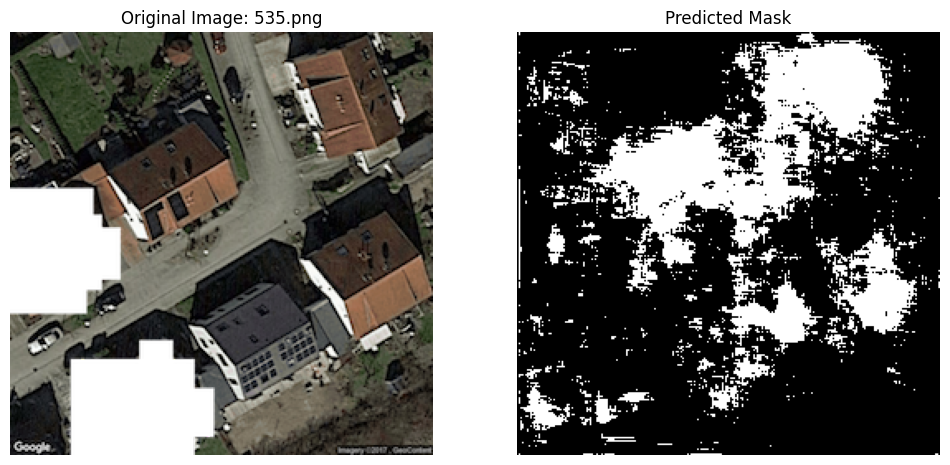

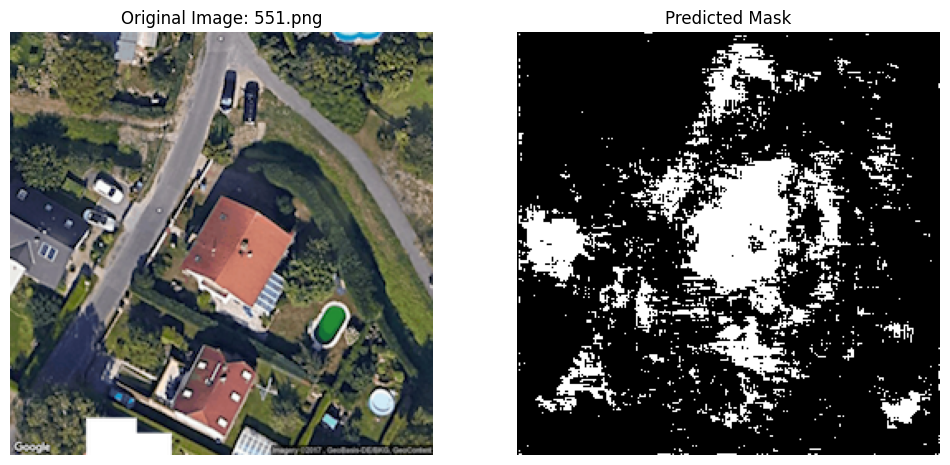

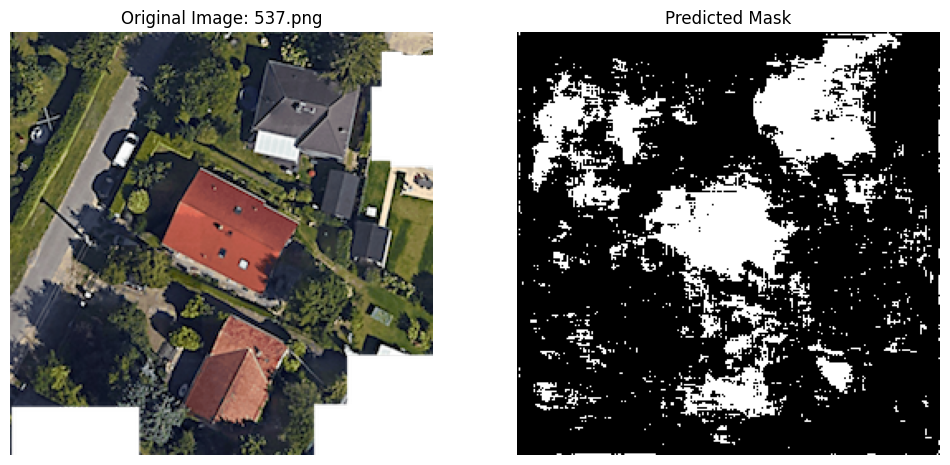

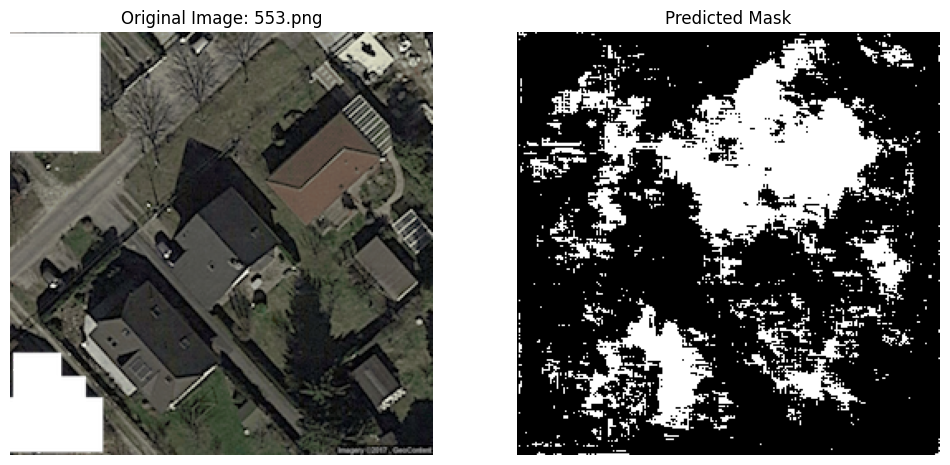

In [ ]:
model.eval()

images_to_predict_files = os.listdir(to_predict)

for image_file in images_to_predict_files:
    image_path = os.path.join(to_predict, image_file)

    # Load and preprocess the image
    image_pil = Image.open(image_path)
    image_tensor = ToTensor()(image_pil).unsqueeze(0).to(device)

    # Predict with the final model
    with torch.no_grad():
        prediction = model(image_tensor)

    # Process the prediction
    predicted_mask = (prediction.squeeze(0).cpu().numpy() > 0.5).astype(np.uint8)

    # Display the original image and the predicted mask side-by-side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image_pil))
    plt.title(f"Original Image: {image_file}")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()